Using Land Processors 5x13 compared to 5x13 run

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [24]:
#load in the datas. Trying something new with dict objects...

#first run 
r1 = 'No LPE'
runname1 = ('/data/mdunphy/compare/')
print (runname1)

#second run 
r2 = 'LPE'
runname2 = ('/data/mdunphy/compare/')
print (runname2)

runs = {r1: runname1, r2: runname2}


/data/mdunphy/compare/
/data/mdunphy/compare/


In [25]:
fUs={}; fVs={}; fTs={}
for key, path in runs.items():
    if key == r1:
        fUs[key] = NC.Dataset(path +'/SalishSea_1d_20150612_20150612_grid_U-5x13.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1d_20150612_20150612_grid_V-5x13.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1d_20150612_20150612_grid_T-5x13.nc','r');
    else:
        fUs[key] = NC.Dataset(path +'/SalishSea_1d_20150612_20150612_grid_U-5x13-LPE.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1d_20150612_20150612_grid_V-5x13-LPE.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1d_20150612_20150612_grid_T-5x13-LPE.nc','r');

Show info about the files

In [26]:
for key in runs:
    print (key)
    nc_tools.show_dataset_attrs(fUs[key])

No LPE
file format: NETCDF4
name: SalishSea_1d_20150612_20150612
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-Oct-28 00:07:20 PDT
LPE
file format: NETCDF4
name: SalishSea_1d_20150612_20150612
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-Oct-28 00:49:10 PDT


In [27]:
for key in runs:
    print (key)
    nc_tools.show_variable_attrs(fUs[key])

No LPE
<class 'netCDF4._netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    nav_model: grid_U
    bounds: bounds_lat
unlimited dimensions: 
current shape = (898, 398)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    nav_model: grid_U
    bounds: bounds_lon
unlimited dimensions: 
current shape = (898, 398)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 bounds_lon(y, x, nvertex)
unlimited dimensions: 
current shape = (898, 398, 4)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 bounds_lat(y, x, nvertex)
unlimited dimensions: 
current shape = (898, 398, 4)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 area(y, x)
    standard_name: cell_area
    units: m2
unlimited dimensions: 
current shape = (898, 398)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 depthu(depthu)
    long_name:

Both have 1 time step

In [28]:
#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}; Ds={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    Ds[key] = fTs[key].variables['deptht']
    tim_count[key] = fUs[key].variables['time_counter']
    
t_orig[r1] = datetime.datetime.strptime(
                    tim_count[r1].time_origin.title(), '%Y-%m-%d %H:%M:%S')
t_orig[r2] = datetime.datetime.strptime(
                tim_count[r2].time_origin.title(), '%Y-%m-%d %H:%M:%S')


### Comparison plots

Quick look at surface fields near the start and at end of run

In [29]:
def plot_variable(t,depthlevel,var, var_name,vmin=-3,vmax=3,diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False):
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
        print (var_name, 'max', np.max(var[r1][t,:,:]-var[r2][t,:,:]), 
               'min', np.min(var[r1][t,:,:]-var[r2][t,:,:]))
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
        print (var_name, 'max', np.max(var[r1][t, depthlevel, :, :]-var[r2][t, depthlevel, :, :]), 
               'min', np.min(var[r1][t, depthlevel, :, :] - var[r2][t, depthlevel, :, :]))
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)

Initial time, surface

Time = 0, depth level = 0
U [m/s] max 0.00140767 min -0.000117242
V [m/s] max 0.00114769 min -0.00110291
SSH [m] max 1.95131e-05 min -2.16626e-05
Sal [g/kg] max 7.62939e-05 min -8.7738e-05
Temp [deg C] max 0.000266075 min -0.000155449


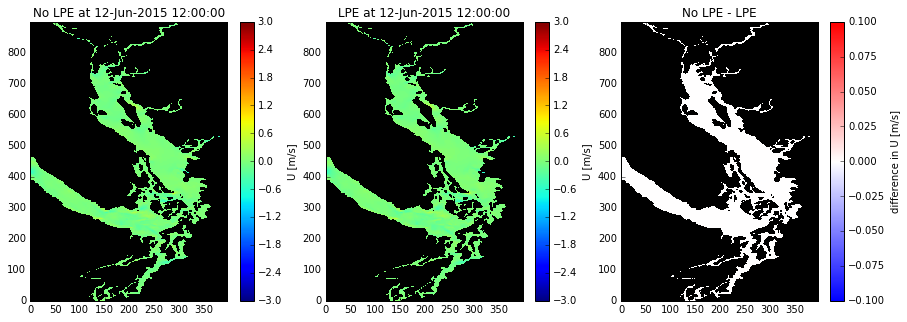

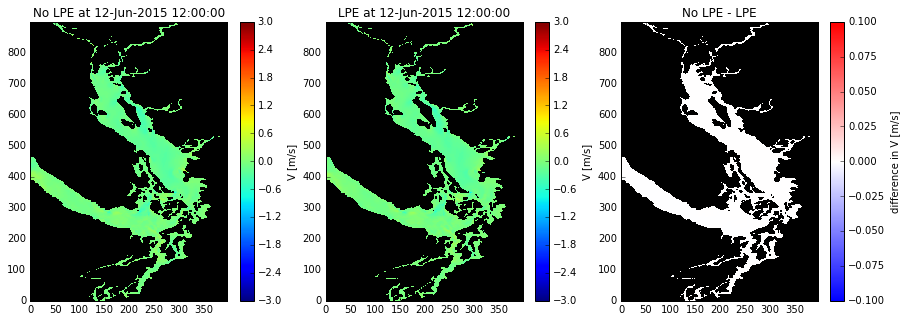

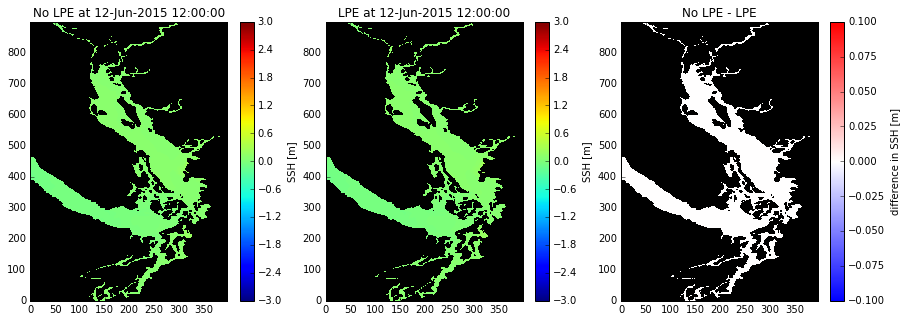

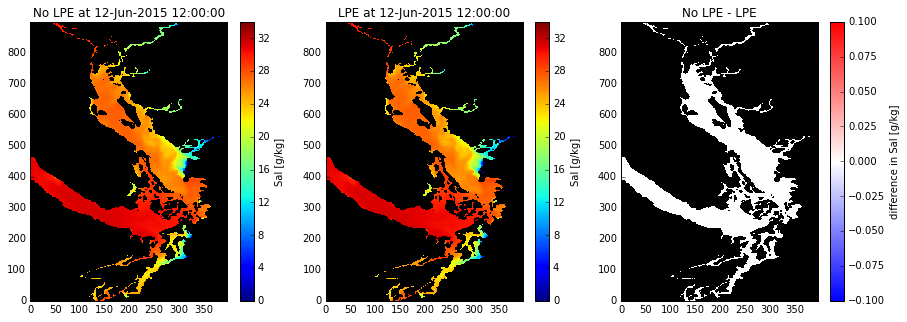

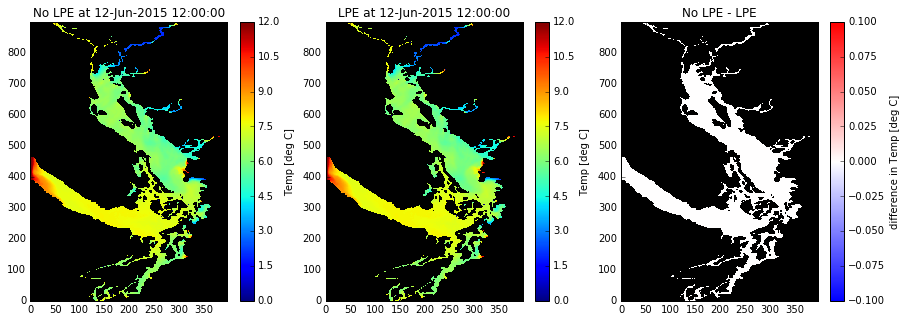

In [30]:
t=0
depthlevel=0

print ('Time = {}, depth level = {}'.format(t,depthlevel))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

Differences are very small.

Time = 0, depth level = 25, depth 76.58558654785156 m
U [m/s] max 0.0013838 min -0.000973552
V [m/s] max 0.000336594 min -0.00076963
SSH [m] max 1.95131e-05 min -2.16626e-05
Sal [g/kg] max 0.000148773 min -0.000137329
Temp [deg C] max 0.000198364 min -0.00023365


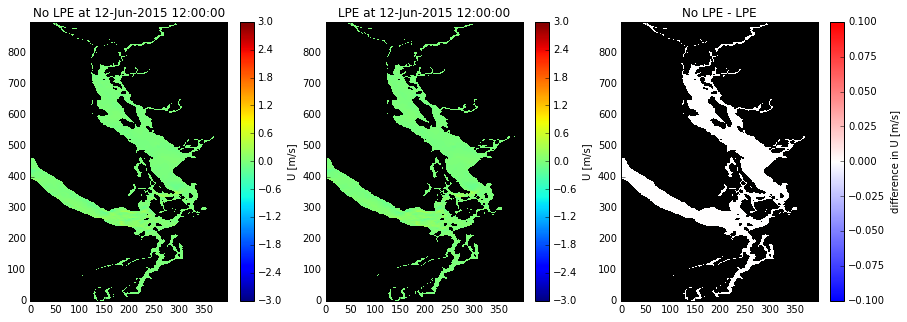

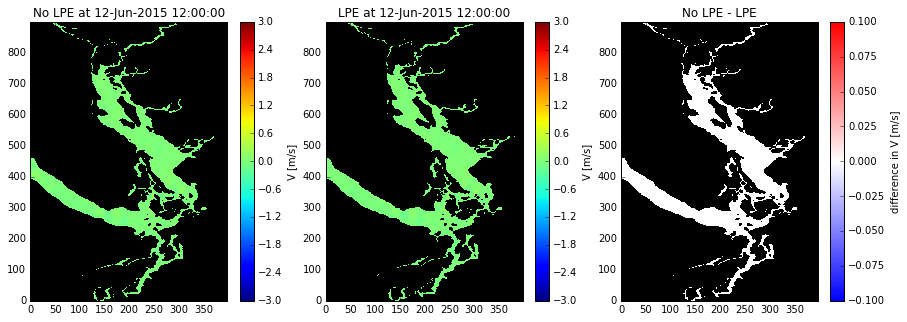

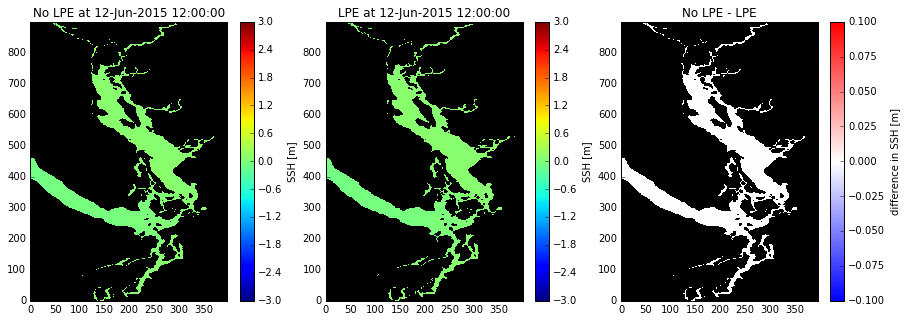

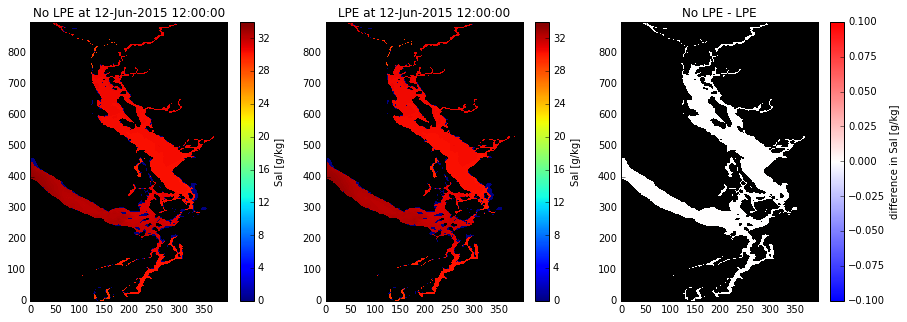

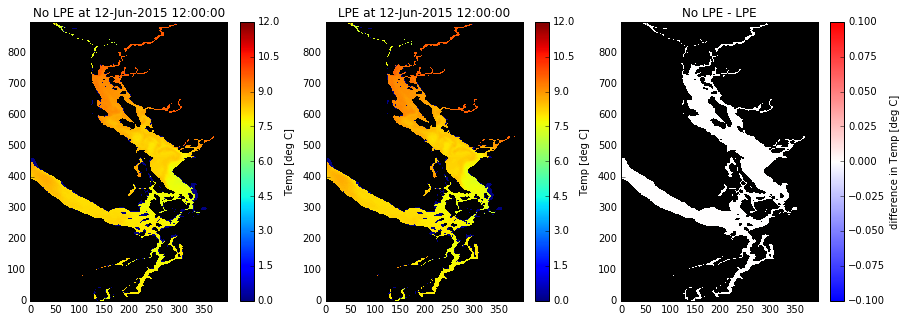

In [31]:
t = 0
depthlevel = 25

print ('Time = {}, depth level = {}, depth {} m'.format(t, depthlevel, Ds[r1][depthlevel]))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

Differences are very small.

## Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [32]:
def summarize_differences(var, var_name, imin=0, imax=396, jmin=0, jmax=896, ts=64):
    diff = var[r1][0:ts,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print (var_name)
    print ('min diff: {0:.3}, index {1}'.format(diff.min(),inds_min))
    print ('max diff: {0:.3}, index {1}'.format(diff.max(),inds_max))
    print ('mean diff {0:.3}'.format(diff.mean()))

In [33]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [psu]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key], key, ts=64)

SSH [m]
min diff: -2.17e-05, index (0, 425, 1)
max diff: 1.95e-05, index (0, 425, 3)
mean diff 6.62e-09
V [m/s]
min diff: -0.00278, index (0, 21, 425, 3)
max diff: 0.0038, index (0, 20, 425, 2)
mean diff -3.25e-09
Temp [deg C]
min diff: -0.00137, index (0, 18, 425, 2)
max diff: 0.00138, index (0, 16, 425, 5)
mean diff 4.44e-09
U [m/s]
min diff: -0.00805, index (0, 16, 425, 1)
max diff: 0.00446, index (0, 7, 425, 2)
mean diff 5.62e-09
Sal [psu]
min diff: -0.000645, index (0, 18, 426, 3)
max diff: 0.000788, index (0, 18, 425, 2)
mean diff -2.03e-09


* Differences are very small

# Closer look at currents at JdFS boundary

Compare fields over depth and along the JdF boundary

In [34]:
def compare_boundary(var, var_name, irange, jrange, t,vmin=-1,vmax=1,diffmin=-0.5,diffmax=0.5):
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2],[r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var,vmin=vmin,vmax=vmax, cmap='viridis')
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff,vmin=diffmin, vmax=diffmax, cmap='bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Mouth of JdF at t = 0


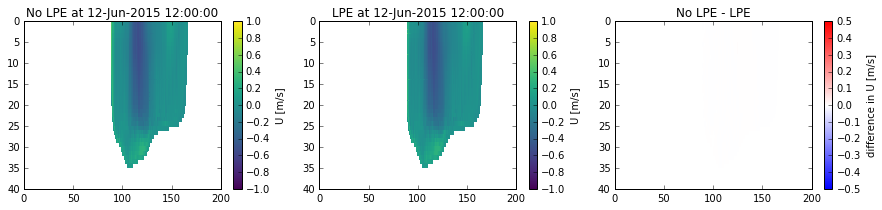

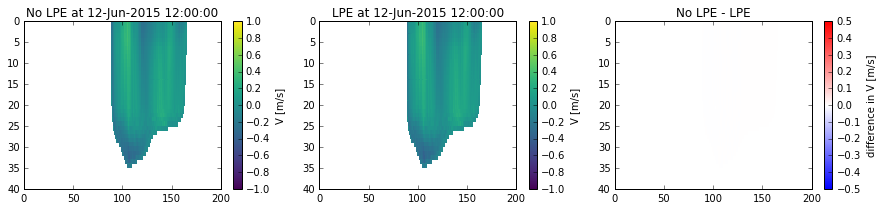

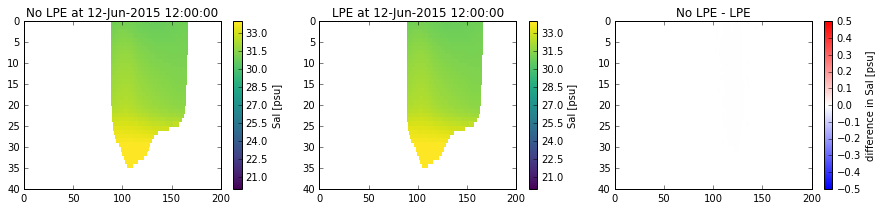

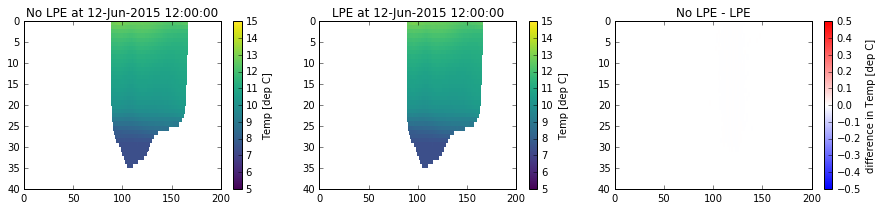

In [35]:
t=0
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print ('Mouth of JdF at t = {}'.format(t))

## Thalwegs

In [36]:
from salishsea_tools import visualisations as vis

In [37]:
print (Ss[r1])
mesh_mask = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

<class 'netCDF4._netCDF4.Variable'>
float32 vosaline(time_counter, deptht, y, x)
    standard_name: sea_water_practical_salinity
    long_name: salinity
    units: 1e-3
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 d
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered deptht nav_lon nav_lat
unlimited dimensions: time_counter
current shape = (1, 40, 898, 398)
filling on


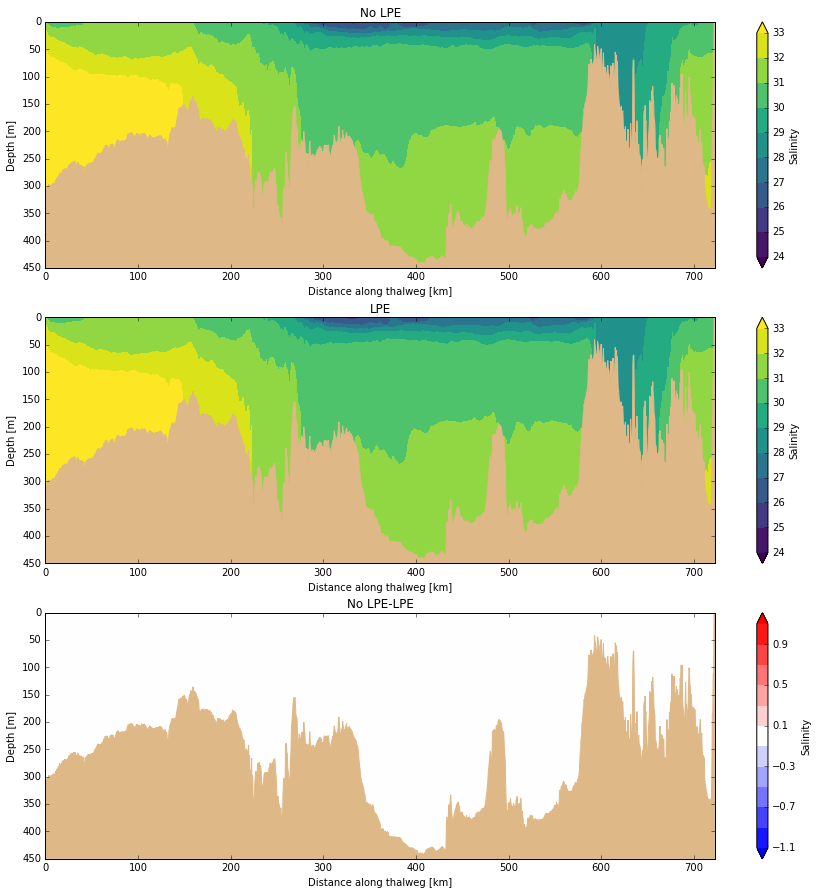

In [43]:
t=0
fig,ax = plt.subplots(3,1,figsize=(15,15))
clevels = np.arange(24., 34., 1)

cbar = vis.contour_thalweg(ax[0], Ss[r1][t], bathy, X, Y, mesh_mask, 'gdept_0', clevels, cmap='viridis')
ax[0].set_ylim([450,0])
cbar.set_label('Salinity')
ax[0].set_title(r1)

cbar = vis.contour_thalweg(ax[1], Ss[r2][t], bathy, X, Y, mesh_mask, 'gdept_0', clevels, cmap='viridis')
ax[1].set_ylim([450,0])
cbar.set_label('Salinity')
ax[1].set_title(r2)

clevels = np.arange(-1.1, 1.11, 0.2)
cbar = vis.contour_thalweg(ax[2], Ss[r1][t]-Ss[r2][t], bathy, X, Y, mesh_mask, 'gdept_0', clevels, 
                           cmap='bwr')
ax[2].set_ylim([450,0])
cbar.set_label('Salinity')
ax[2].set_title(r1+"-"+r2)

No differences.